<a href="https://colab.research.google.com/github/DGuilherme/AAUTIA2/blob/main/run_doc2vec_lee_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Doc2Vec Model
=============

Introduces Gensim's Doc2Vec model and demonstrates its use on the
`Lee Corpus <https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`__.




# Imports


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [18]:
# CH3 imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

Doc2Vec is a `core_concepts_model` that represents each
`core_concepts_document` as a `core_concepts_vector`.  This
tutorial introduces the model and demonstrates how to train and assess it.

Here's a list of what we'll be doing:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

Review: Bag-of-words
--------------------

.. Note:: Feel free to skip these review sections if you're already familiar with the models.

You may be familiar with the `bag-of-words model
<https://en.wikipedia.org/wiki/Bag-of-words_model>`_ from the
`core_concepts_vector` section.
This model transforms each document to a fixed-length vector of integers.
For example, given the sentences:

- ``John likes to watch movies. Mary likes movies too.``
- ``John also likes to watch football games. Mary hates football.``

The model outputs the vectors:

- ``[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]``
- ``[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]``

Each vector has 10 elements, where each element counts the number of times a
particular word occurred in the document.
The order of elements is arbitrary.
In the example above, the order of the elements corresponds to the words:
``["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"]``.

Bag-of-words models are surprisingly effective, but have several weaknesses.

First, they lose all information about word order: "John likes Mary" and
"Mary likes John" correspond to identical vectors. There is a solution: bag
of `n-grams <https://en.wikipedia.org/wiki/N-gram>`__
models consider word phrases of length n to represent documents as
fixed-length vectors to capture local word order but suffer from data
sparsity and high dimensionality.

Second, the model does not attempt to learn the meaning of the underlying
words, and as a consequence, the distance between vectors doesn't always
reflect the difference in meaning.  The ``Word2Vec`` model addresses this
second problem.

Review: ``Word2Vec`` Model
--------------------------

``Word2Vec`` is a more recent model that embeds words in a lower-dimensional
vector space using a shallow neural network. The result is a set of
word-vectors where vectors close together in vector space have similar
meanings based on context, and word-vectors distant to each other have
differing meanings. For example, ``strong`` and ``powerful`` would be close
together and ``strong`` and ``Paris`` would be relatively far.

Gensim's :py:class:`~gensim.models.word2vec.Word2Vec` class implements this model.

With the ``Word2Vec`` model, we can calculate the vectors for each **word** in a document.
But what if we want to calculate a vector for the **entire document**\ ?
We could average the vectors for each word in the document - while this is quick and crude, it can often be useful.
However, there is a better way...

Introducing: Paragraph Vector
-----------------------------

.. Important:: In Gensim, we refer to the Paragraph Vector model as ``Doc2Vec``.

Le and Mikolov in 2014 introduced the `Doc2Vec algorithm <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`__,
which usually outperforms such simple-averaging of ``Word2Vec`` vectors.

The basic idea is: act as if a document has another floating word-like
vector, which contributes to all training predictions, and is updated like
other word-vectors, but we will call it a doc-vector. Gensim's
:py:class:`~gensim.models.doc2vec.Doc2Vec` class implements this algorithm.

There are two implementations:

1. Paragraph Vector - Distributed Memory (PV-DM)
2. Paragraph Vector - Distributed Bag of Words (PV-DBOW)

.. Important::
  Don't let the implementation details below scare you.
  They're advanced material: if it's too much, then move on to the next section.

PV-DM is analogous to Word2Vec CBOW. The doc-vectors are obtained by training
a neural network on the synthetic task of predicting a center word based an
average of both context word-vectors and the full document's doc-vector.

PV-DBOW is analogous to Word2Vec SG. The doc-vectors are obtained by training
a neural network on the synthetic task of predicting a target word just from
the full document's doc-vector. (It is also common to combine this with
skip-gram testing, using both the doc-vector and nearby word-vectors to
predict a single target word, but only one at a time.)

Prepare the Training and Test Data
----------------------------------

For this tutorial, we'll be training our model using the `Lee Background
Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
included in gensim. This corpus contains 314 documents selected from the
Australian Broadcasting Corporation’s news mail service, which provides text
e-mails of headline stories and covers a number of broad topics.

And we'll test our model by eye using the much shorter `Lee Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
which contains 50 documents.




In [4]:
# resolver problema de gensim version
!pip install --upgrade gensim

     |████████████████████████████████| 23.9MB 154kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
# Dataset Chalenge 3
# raw: https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset.txt


url = 'https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset.txt'
#train_data = pd.read_csv(url,delimiter=r"|")
# Dataset is now stored in a Pandas Dataframe

url10000 = 'https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset10000.txt'

train_data_unsplit = pd.read_json(url10000)
train_data_unsplit = train_data_unsplit.rename(columns={'_id': 'ID', 'abstract': 'Resumo','title': 'Titulo'})
train_data_unsplit = train_data_unsplit.dropna()
train_data_unsplit = train_data_unsplit.drop_duplicates(subset ="Resumo",keep = False)
train_data_unsplit = train_data_unsplit.drop_duplicates(subset ="Titulo",keep = False)


from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_data_unsplit, test_size=0.2)

2021-04-15 18:41:41,685 : INFO : NumExpr defaulting to 2 threads.


In [6]:
train_data[train_data.duplicated(subset=['Titulo'],keep=False)]




,ID,Resumo,Titulo


In [7]:
test_data.describe()

,ID,Resumo,Titulo
count,1939,1939,1939
unique,1939,1939,1939
top,57025eb6eb1ec9f5515f9bd3,An apparatus is disclosed for longitudinally c...,Tube and fitting structure
freq,1,1,1


In [43]:

import gensim
def tagData(dataframe):
  number = 0
  for index,row in dataframe.iterrows():
    number = number + 1
    resumotokens = gensim.utils.simple_preprocess(row['Resumo'])
    #titulotokens = gensim.utils.simple_preprocess(row['Titulo'])

    yield gensim.models.doc2vec.TaggedDocument(resumotokens, [number]) #yield gensim.utils.simple_preprocess(row['Resumo'])


vocabulary = list(tagData(train_data))
vocabulary_test = list(tagData(test_data))






In [55]:
data = {'ID': ['57025eb6eb1ec9f5515f7c33'], 'Resumo': ['A damper for use in submerged hydrophone suspension systems including an elongated mass cylinder defined by a tube of flexible synthetic plastic film utilizing a check valve located at each end permitting water to enter the tube and preventing egress. Additionally, each tube end is provided with a disk transversely disposed to the tube length and of a diameter substantially greater than that of the tube to provide drag and hydrodynamic mass damping. The tube and disk are of a configuration to eliminate vortex shedding and the entire damper assembly is capable of being folded and packed within a concise configuration prior to deployment.'], 'Titulo': ['Hydrophone damper assembly']}
user_input_dataframe = pd.DataFrame(data)

user_input_dataframe.describe()
user_question = list(tagData(user_input_dataframe))


# Vocabulary

In [56]:
#user_question.describe()
# print(user_input_dataframe)
# print(vocabulary)
# print(vocabulary_test)
print(user_question)

[TaggedDocument(words=['damper', 'for', 'use', 'in', 'submerged', 'hydrophone', 'suspension', 'systems', 'including', 'an', 'elongated', 'mass', 'cylinder', 'defined', 'by', 'tube', 'of', 'flexible', 'synthetic', 'plastic', 'film', 'utilizing', 'check', 'valve', 'located', 'at', 'each', 'end', 'permitting', 'water', 'to', 'enter', 'the', 'tube', 'and', 'preventing', 'egress', 'additionally', 'each', 'tube', 'end', 'is', 'provided', 'with', 'disk', 'transversely', 'disposed', 'to', 'the', 'tube', 'length', 'and', 'of', 'diameter', 'substantially', 'greater', 'than', 'that', 'of', 'the', 'tube', 'to', 'provide', 'drag', 'and', 'hydrodynamic', 'mass', 'damping', 'the', 'tube', 'and', 'disk', 'are', 'of', 'configuration', 'to', 'eliminate', 'vortex', 'shedding', 'and', 'the', 'entire', 'damper', 'assembly', 'is', 'capable', 'of', 'being', 'folded', 'and', 'packed', 'within', 'concise', 'configuration', 'prior', 'to', 'deployment'], tags=[1])]


93.0

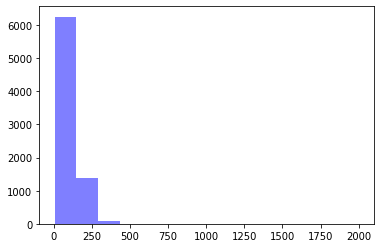

In [9]:
text_length = [len(entry.words) for entry in vocabulary]
plt.hist(text_length, facecolor='blue', alpha=0.5, bins= 'sturges')
import numpy as np
np.median( text_length)

In [10]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=250) # Create inital empty model

2021-04-15 18:41:45,731 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3)', 'datetime': '2021-04-15T18:41:45.731247', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


Build a vocabulary



In [11]:
model.build_vocab(vocabulary) # Add data to the model

2021-04-15 18:41:45,746 : INFO : collecting all words and their counts
2021-04-15 18:41:45,749 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-04-15 18:41:45,958 : INFO : collected 19766 word types and 7753 unique tags from a corpus of 7752 examples and 829777 words
2021-04-15 18:41:45,959 : INFO : Creating a fresh vocabulary
2021-04-15 18:41:46,031 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 13174 unique words (66.64980269149044%% of original 19766, drops 6592)', 'datetime': '2021-04-15T18:41:46.031886', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-04-15 18:41:46,033 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 823185 word corpus (99.20556968920566%% of original 829777, drops 6592)', 'datetime': '2021-04-15T18:41:46.033745', 'gensim': '4.0.1', 'python': '3.7.10 (

Essentially, the vocabulary is a list (accessible via
``model.wv.index_to_key``) of all of the unique words extracted from the training corpus.
Additional attributes for each word are available using the ``model.wv.get_vecattr()`` method,
For example, to see how many times ``penalty`` appeared in the training corpus:




In [12]:
print("Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.


Next, train the model on the corpus.
If optimized Gensim (with BLAS library) is being used, this should take no more than 3 seconds.
If the BLAS library is not being used, this should take no more than 2
minutes, so use optimized Gensim with BLAS if you value your time.




In [13]:
model.train(vocabulary, total_examples=model.corpus_count, epochs=model.epochs)

2021-04-15 18:41:46,366 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 13174 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5', 'datetime': '2021-04-15T18:41:46.366484', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-04-15 18:41:47,383 : INFO : EPOCH 1 - PROGRESS: at 48.04% examples, 295759 words/s, in_qsize 5, out_qsize 0
2021-04-15 18:41:48,404 : INFO : EPOCH 1 - PROGRESS: at 95.65% examples, 292836 words/s, in_qsize 4, out_qsize 0
2021-04-15 18:41:48,462 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-15 18:41:48,492 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-15 18:41:48,493 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-15 18:41:48,494 : INFO : EPOCH - 1 : training on 829777 raw words (620220 effective words) took 2.1

Now, we can use the trained model to infer a vector for any piece of text
by passing a list of words to the ``model.infer_vector`` function. This
vector can then be compared with other vectors via cosine similarity.




In [14]:
vector = model.infer_vector(['overspeed', 'shutoff' ,'device', 'for' ,'use'])
print(vector)

[ 0.19461125  0.15426297 -0.06778453 -0.13812745  0.56232864 -0.46457142
  0.03969078  0.5934011  -0.5312617  -0.09241747 -0.37831476 -0.02183417
  0.08179954 -0.2139268  -0.7073094  -0.6057121   0.47982717 -1.1621062
 -0.11787821 -2.1566458   0.613164    0.00673444  1.4512098  -0.18487066
 -0.19563945 -0.07227802 -0.57882327  0.04518209 -0.89547175 -0.56909436
  0.48809373  0.87917954  0.7153869  -0.13968179  0.26915088  0.60708714
  0.04066347 -0.24510045  0.68775463 -0.23525445  0.50920695  0.6664235
 -0.99655557  0.60794276  0.46611717 -0.02282776 -0.76489747  0.01801522
 -0.07184638  1.5107402   0.08347482  0.10847268 -0.16278706  0.74159753
 -1.060348    0.957966    0.2243879  -0.2330689  -0.5662789   0.38183072
  1.4271612  -0.17428783  0.11455578  0.37213403 -0.54082274  0.28041458
 -0.42853522  0.24056329  0.54431576  0.29814366 -0.8843316   0.08172166
  0.6096787  -0.8133849  -0.19991438 -0.49786392  0.7364909  -0.1654143
 -0.9641195   0.10903215 -0.19367205  0.319545    0.06

Note that ``infer_vector()`` does *not* take a string, but rather a list of
string tokens, which should have already been tokenized the same way as the
``words`` property of original training document objects.

Also note that because the underlying training/inference algorithms are an
iterative approximation problem that makes use of internal randomization,
repeated inferences of the same text will return slightly different vectors.




Assessing the Model
-------------------

To assess our new model, we'll first infer new vectors for each document of
the training corpus, compare the inferred vectors with the training corpus,
and then returning the rank of the document based on self-similarity.
Basically, we're pretending as if the training corpus is some new unseen data
and then seeing how they compare with the trained model. The expectation is
that we've likely overfit our model (i.e., all of the ranks will be less than
2) and so we should be able to find similar documents very easily.
Additionally, we'll keep track of the second ranks for a comparison of less
similar documents.




In [15]:
ranks = []
second_ranks = []
for doc_id in range(len(vocabulary)):
    inferred_vector = model.infer_vector(vocabulary[doc_id].words) # uses the model to create the vector
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade  
    rank = [docid for docid, sim in sims].index(doc_id) 
    ranks.append(rank)

    second_ranks.append(sims[1])

Let's count how each document ranks with respect to the training corpus

NB. Results vary between runs due to random seeding and very small corpus



In [16]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({6719: 7, 1460: 6, 311: 6, 6050: 6, 5219: 6, 6137: 6, 720: 6, 5964: 5, 1686: 5, 3557: 5, 7100: 5, 6143: 5, 2334: 5, 2831: 5, 697: 5, 2909: 5, 735: 5, 2160: 5, 7335: 5, 1998: 5, 963: 5, 4274: 5, 5082: 5, 4417: 5, 6320: 5, 330: 5, 5058: 5, 1196: 5, 7132: 5, 1890: 4, 1394: 4, 1640: 4, 7248: 4, 2133: 4, 3691: 4, 6837: 4, 6789: 4, 2823: 4, 6625: 4, 6457: 4, 580: 4, 3449: 4, 7001: 4, 118: 4, 4428: 4, 1484: 4, 18: 4, 6334: 4, 6157: 4, 1371: 4, 3080: 4, 2346: 4, 3047: 4, 1114: 4, 3356: 4, 5971: 4, 491: 4, 4774: 4, 7279: 4, 949: 4, 2566: 4, 5638: 4, 2530: 4, 3286: 4, 6670: 4, 7124: 4, 5728: 4, 3938: 4, 6159: 4, 5698: 4, 4017: 4, 6682: 4, 6247: 4, 425: 4, 2760: 4, 6126: 4, 1711: 4, 6911: 4, 6356: 4, 551: 4, 716: 4, 3706: 4, 1473: 4, 7550: 4, 3522: 4, 4049: 4, 6222: 4, 3983: 4, 4540: 4, 2649: 4, 6552: 4, 2163: 4, 4329: 4, 2171: 4, 1787: 4, 2839: 4, 7145: 4, 7720: 4, 2879: 4, 7134: 4, 1815: 4, 4642: 4, 3232: 4, 5398: 4, 4171: 4, 1941: 4, 7140: 4, 7416: 4, 5187: 4, 6318: 4, 3997: 4, 675: 4,

Basically, greater than 95% of the inferred documents are found to be most
similar to itself and about 5% of the time it is mistakenly most similar to
another document. Checking the inferred-vector against a
training-vector is a sort of 'sanity check' as to whether the model is
behaving in a usefully consistent manner, though not a real 'accuracy' value.

This is great and not entirely surprising. We can take a look at an example:




In [19]:
doc_id = random.randint(0, len(vocabulary) - 1)
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(vocabulary[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)


Document (5268): «container having cover the container having rim and first curled edge at the rim portion of the first curled edge having its biggest diameter in plane perpendicular to the center line of the container the cover having second curled edge gripping around the first curled edge the second curled edge including circumferential cutting line which flows up and down with peaks at region of or above the portion of the first curl having the biggest diameter and with valleys underneath the portion»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3):



Notice above that the most similar document (usually the same text) is has a
similarity score approaching 1.0. However, the similarity score for the
second-ranked documents should be significantly lower (assuming the documents
are in fact different) and the reasoning becomes obvious when we examine the
text itself.

We can run the next cell repeatedly to see a sampling other target-document
comparisons.




In [20]:
print(train_data.iloc[499]['Titulo'],' | ',train_data.iloc[499]['Resumo'])

print(train_data.iloc[496]['Titulo'],' | ',train_data.iloc[496]['Resumo'])

print(train_data.iloc[181]['Titulo'],' | ',train_data.iloc[181]['Resumo'])





Circuit arrangement for detecting double connections in digital       telecommunication switching systems  |  Apparatus is described for detecting undesirable duplications in connections in time division multiplex telecommunication systems, e.g., pulse code modulated telephone systems. The multiplex trunks are coupled through time coupling stages which may take the form of storages allocated to individual trunks, and the trunks are connectable in pairs, by means of cross-point switches, over pairs of time multiplex channels to outgoing time division multiplex trunks. A parity generator and an OR gate are inserted between the trunk-challel side terminals of the crosspoint switches extending from the incoming trunk in question to the same trunk and the trunk in question. An output of the parity generator is coupled, along with an output of the OR gate, to an exclusive OR gate, which produces an output signal responsive to a dissimilarity in inputs. The appearance of the latter output sig

In [21]:
# Pick a random document from the corpus and infer a vector from the model
import random


doc_id = random.randint(0, len(vocabulary_test) - 1)

inferred_vector = model.infer_vector(vocabulary_test[doc_id].words) # uses the model to create the vector
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade 
print(sims)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
  print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(vocabulary[sims[index][0]].words)))

[(2802, 0.46195629239082336), (6417, 0.41833627223968506), (6100, 0.40878570079803467), (6864, 0.4004014730453491), (4408, 0.37645843625068665), (759, 0.3703632652759552), (3967, 0.36739638447761536), (6758, 0.3666098117828369), (3317, 0.36632224917411804), (744, 0.3647509217262268), (2538, 0.3612479567527771), (3828, 0.352681040763855), (4245, 0.3512513339519501), (5724, 0.34728217124938965), (3625, 0.34498798847198486), (3685, 0.34141847491264343), (5366, 0.3405866324901581), (1304, 0.3393780589103699), (2466, 0.3376457095146179), (155, 0.3372668921947479), (218, 0.33500075340270996), (6855, 0.3344561457633972), (4958, 0.33307331800460815), (7278, 0.3304033875465393), (7122, 0.3289346396923065), (1662, 0.32883980870246887), (4433, 0.32865017652511597), (2988, 0.32723504304885864), (6181, 0.3258819580078125), (1455, 0.32545116543769836), (6562, 0.3250334560871124), (2107, 0.3243539333343506), (7471, 0.3233056366443634), (3009, 0.3220905363559723), (1829, 0.3219263255596161), (6935, 0.

In [96]:
# Pick a random document from the corpus and infer a vector from the model TRAIN DATA
import random


doc_id = random.randint(0, len(vocabulary)-1)

inferred_vector = model.infer_vector(vocabulary[doc_id].words) # uses the model to create the vector
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade 
print(str(doc_id) + ' | '+' '.join(vocabulary[doc_id].words))
for label, index in [('MOST', 0), ('SECOND-MOST', 1),('SECOND-MOST', 2),('SECOND-MOST', 3), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
  print(u'%s (%s,%s): «%s»\n' % (label, sims[index][0]-1,sims[index][1], ' '.join(vocabulary[sims[index][0]-1].words)))

5235 | wheel having pair of spaced apart seats for tire beads and annular axially extending rim portions extending from adjacent the bead seats and forming faces against which sidewall of tire can be deflected and supported when the tire is deflated
MOST (5235,0.9706439971923828): «wheel having pair of spaced apart seats for tire beads and annular axially extending rim portions extending from adjacent the bead seats and forming faces against which sidewall of tire can be deflected and supported when the tire is deflated»

SECOND-MOST (581,0.5187333226203918): «mold provided with specially configured blades for forming correspondingly configured recesses in ribs shaped in the tire tread by number of grooves which generally extend in circumferential direction about the tire»

MEDIAN (1430,0.17111842334270477): «there is disclosed composition comprising approximately by weight to of copolymer of an ethylenically unsaturated polymeric anhydride or partial ester and an ethylenically unsatur

In [58]:
# Pick a random document from the corpus and infer a vector from the model TRAIN DATA
import random


#doc_id = random.randint(0, len(user_question) - 1)

inferred_vector = model.infer_vector(user_question[0].words) # uses the model to create the vector
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade 
#print(sims)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
  print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(vocabulary[sims[index][0]].words)))

MOST (5388, 0.991133987903595): «in continuous fuel fired glass melting furnace pair of substantially horizontal longitudinally extending electrodes are provided in the molten glass closely adjacent to the sides of the floating batch blanket for supplying electrically generated booster heat to the underside of the batch blanket the electrodes extend substantial distance into the melting zone of the furnace through the fill end wall the electrodes also serve as physical barriers that prevent the batch blanket from drifting into contact with sidewalls of the furnace the electrode arrangement boosts melting rates with efficient utilization of electrical energy and avoids furnace wall erosion and unbalanced melting conditions»

SECOND-MOST (4597, 0.49290168285369873): «gear driven transport ring rotates around toroidal chamber spaced sealing rings carried by the transport ring divide the chamber into compartments which serve to transport liquid from feed station to discharge station gas or

In [37]:
doc_id = random.randint(0, len(vocabulary_test) - 1)
print(vocabulary_test[doc_id])
print(user_question[0])


TaggedDocument(['the', 'measurement', 'of', 'tire', 'is', 'displayed', 'during', 'rotation', 'of', 'the', 'tire', 'and', 'buffing', 'thereof', 'by', 'an', 'apparatus', 'and', 'method', 'in', 'which', 'first', 'train', 'of', 'electrical', 'pulse', 'signals', 'are', 'generated', 'which', 'characterize', 'the', 'rotational', 'speed', 'of', 'the', 'tire', 'second', 'train', 'of', 'electrical', 'pulse', 'signals', 'are', 'generated', 'which', 'characterize', 'the', 'linear', 'surface', 'speed', 'of', 'the', 'crown', 'surface', 'of', 'the', 'tire', 'which', 'is', 'being', 'buffed', 'and', 'the', 'ratio', 'of', 'pulses', 'in', 'the', 'two', 'trains', 'is', 'displayed', 'as', 'indicative', 'of', 'measurement', 'of', 'the', 'tire'], [1374])
['hydrophone', 'damper', 'assembly']


In [60]:

inferred_vector_1 = model.infer_vector(user_question[0].words)
print(inferred_vector_1)

inferred_vector_2 = model.infer_vector(user_question[0].words)



[-3.6520433e+00  1.6498220e+00  1.2883828e+00 -4.5012221e+00
 -8.2395607e-01 -3.7614510e+00  2.5249088e+00  2.0371108e+00
  4.2930695e-01 -2.1174631e+00 -3.0624747e+00 -3.5126636e+00
  2.0488272e+00 -5.6355196e-01 -6.7841822e-01 -2.2578988e+00
  1.5309476e+00  1.5584751e+00 -5.1898491e-01 -1.8501290e+00
  3.0939233e+00  5.5029947e-01 -1.3080287e+00 -1.6625614e+00
  1.5527682e-01 -1.6290767e+00 -1.4270124e+00 -4.2985129e-01
 -2.7289860e+00 -1.8336645e+00  7.8306103e-01  4.4390745e+00
 -3.6113026e+00  5.0711322e-01  3.0218945e+00  1.5161191e+00
 -4.0586996e+00 -5.0299644e+00  1.5911486e+00  1.0038335e+00
  8.5114676e-01 -1.2089113e-01  1.0390877e+00 -6.8600732e-01
 -2.4266326e+00 -2.1488941e+00 -2.1604815e+00 -2.8807547e+00
 -1.2429820e+00 -2.1900282e+00 -2.4426930e+00  3.9598861e-01
 -1.3601210e+00  2.3941629e+00 -2.3743114e+00 -6.0886145e-01
  2.9802356e+00 -6.9209349e-01  1.3264710e+00 -2.7247810e+00
  5.7968020e+00 -9.7388193e-02  1.2972587e+00  4.5404845e-01
 -3.4036906e+00  1.22312

In [75]:
#model.wv.n_similarity(user_question[0].words,user_question[0].words)

#model.dv.n_similarity(user_question[0].words.tolist(),user_question[0].words.tolist())

#model.wv.cosine_similarities(user_question[0].words,user_question[0].words)



wl1 = {'damper', 'for', 'use', 'in', 'submerged', 'hydrophone', 'suspension', 'systems', 'including', 'an', 'elongated', 'mass', 'cylinder', 'defined', 'by', 'tube', 'of', 'flexible', 'synthetic', 'plastic', 'film', 'utilizing', 'check', 'valve', 'located', 'at', 'each', 'end', 'permitting', 'water', 'to', 'enter', 'the'}
wl2 = {'damper', 'for', 'use', 'in', 'submerged', 'hydrophone', 'suspension', 'systems', 'including', 'an', 'elongated', 'mass', 'cylinder', 'defined', 'by', 'tube', 'of', 'flexible', 'synthetic', 'plastic', 'film', 'utilizing', 'check', 'valve', 'located', 'at', 'each', 'end', 'permitting', 'water', 'to', 'enter', 'the'}

model.wv.n_similarity(wl1,wl2)


#print(user_question[0].words)

1.0

Testing the Model
-----------------

Using the same approach above, we'll infer the vector for a randomly chosen
test document, and compare the document to our model by eye.




In [22]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(vocabulary_test) - 1)
inferred_vector = model.infer_vector(vocabulary_test[doc_id].words)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
print(sims)
print(doc_id)

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(vocabulary_test[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0),('Second', 1),('Third', 2), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(vocabulary[sims[index][0]].words)))

[(3260, 0.41773781180381775), (6755, 0.41553542017936707), (4178, 0.389499694108963), (3678, 0.3877698481082916), (4019, 0.38700348138809204), (873, 0.38224244117736816), (7595, 0.3800900876522064), (1038, 0.3799709379673004), (3655, 0.37835031747817993), (6216, 0.3729381263256073), (2375, 0.37287992238998413), (3128, 0.3727433383464813), (2934, 0.37242254614830017), (6457, 0.37013548612594604), (7634, 0.36851000785827637), (1748, 0.36499208211898804), (1923, 0.36433660984039307), (7657, 0.36122754216194153), (6418, 0.36002618074417114), (4846, 0.35936978459358215), (434, 0.3578687012195587), (4136, 0.35778072476387024), (3956, 0.3563879430294037), (1127, 0.3544773459434509), (1573, 0.3542553782463074), (773, 0.3529951870441437), (6990, 0.35206514596939087), (6935, 0.34931689500808716), (1970, 0.34920066595077515), (5201, 0.34868431091308594), (497, 0.34662914276123047), (6101, 0.34646663069725037), (2962, 0.34436237812042236), (5341, 0.3439341187477112), (7010, 0.3432921767234802), (8

Conclusion
----------

Let's review what we've seen in this tutorial:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

That's it! Doc2Vec is a great way to explore relationships between documents.

Additional Resources
--------------------

If you'd like to know more about the subject matter of this tutorial, check out the links below.

* `Word2Vec Paper <https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf>`_
* `Doc2Vec Paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_
* `Dr. Michael D. Lee's Website <http://faculty.sites.uci.edu/mdlee>`_
* `Lee Corpus <http://faculty.sites.uci.edu/mdlee/similarity-data/>`__
* `IMDB Doc2Vec Tutorial <doc2vec-IMDB.ipynb>`_


